# Test 2 - Model without reasoning _vs_ model with reasoning _vs_ models with reasoning every $x$ turns

In [2]:
! tar czf Testing.tar.gz *

In [5]:
! nvidia-smi

Tue Sep  9 13:55:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
|  0%   43C    P8             23W /  450W |      15MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import time
import textworld
import textworld.gym
import numpy as np
import re
import os
from glob import glob
from typing import Mapping, Any
import pickle
import matplotlib.pyplot as plt

In [2]:
import torch
import accelerate
torch.set_default_device('cuda')
# torch.cuda.device("cuda")
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.set_float32_matmul_precision('high')

In [3]:
model_name = "Qwen/Qwen3-4B"

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype="auto",
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
print(model.hf_device_map)

{'': 0}


## Play function

In [5]:
def play(agent, path, max_steps=100, n_episodes=10, verbose=True):
    torch.manual_seed(46)  # For reproducibility when using action sampling.

    infos_to_request = agent.infos_to_request
    infos_to_request.max_score = True  # Needed to normalize the scores.

    gamefiles = [path]
    if os.path.isdir(path):
        gamefiles = glob(os.path.join(path, "*.z8"))

    env_id = textworld.gym.register_games(gamefiles,
                                          request_infos=infos_to_request,
                                          max_episode_steps=max_steps)
    env = textworld.gym.make(env_id)  # Create a Gym environment to play the text game.
    if verbose:
        if os.path.isdir(path):
            print(os.path.dirname(path), end="")
        else:
            print(os.path.basename(path), end="")

    # Collect some statistics
    avg_moves, avg_scores, avg_norm_scores = [], [], []
    moves_scores_times_list = []
    
    for no_episode in range(n_episodes):
        episode_start = time.process_time()
        obs, infos = env.reset()  # Start new episode.

        score = 0
        done = False
        nb_moves = 0
        moves_scores_times = [(0, 0, 0)] # starting point
        
        while not done:
            command = agent.act(obs, score, done, infos)
            timestamp = time.process_time()
            obs, score, done, infos = env.step(command)
            nb_moves += 1
            moves_scores_times.append((nb_moves, score, timestamp - episode_start))

        agent.act(obs, score, done, infos)  # Let the agent know the game is done.
        moves_scores_times_list.append(moves_scores_times)

        if verbose:
            print(".", end="")
        avg_moves.append(nb_moves)
        avg_scores.append(score)
        avg_norm_scores.append(score / infos["max_score"])

    env.close()
    if verbose:
        if os.path.isdir(path):
            msg = "  \tavg. steps: {:5.1f}; avg. normalized score: {:4.1f} / {}."
            print(msg.format(np.mean(avg_moves), np.mean(avg_norm_scores), 1))
            if len(avg_moves) > 1:
                print(f"Detailed steps: {avg_moves}\t Detailed normalized scores: {avg_norm_scores}")
        else:
            msg = "  \tavg. steps: {:5.1f}; avg. score: {:4.1f} / {}."
            print(msg.format(np.mean(avg_moves), np.mean(avg_scores), infos["max_score"]))
            if len(avg_moves) > 1:
                print(f"Detailed steps: {avg_moves}\t Detailed scores: {avg_scores}")
        return moves_scores_times_list

## Agents

In [6]:
class LLMAgent(textworld.gym.Agent):
    """LLM from HuggingFace that acts as an agent."""
    model = None
    tokenizer = None
    context = ""

    token_think = "/think"
    token_nothink = "/no_think"
    id_token_open_think = None # <think> . TODO find it
    id_token_close_think = 151668 # </think>
    token_system = "<|im_start|>system\n"
    token_endofturn = "<|im_end|>\n"
    token_user = "<|im_start|>user\n"
    token_assistant = "<|im_start|>assistant\n"
    system_prompt = """
You are an assistant playing a textual game.
The user gives you information on the environment and you reply exclusively in the form \"verb noun\", like \"open box\" or \"take key\".
/no_think
"""
    first_move = False
    
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.initialize_context()

    def initialize_context(self):
        self.context = self.token_system + self.system_prompt + self.token_endofturn
        self.first_move = True

    @property
    def infos_to_request(self) -> textworld.EnvInfos:
        return textworld.EnvInfos(admissible_commands=True)

    def act(self, obs: str, score: int, done: bool, infos: Mapping[str, Any]) -> str:

        if done:
            self.initialize_context() # resets context
            return ":)"
            
        if self.first_move:
            self.first_move = False
            return "help"
        
        try:
            self.context += self.token_user + obs + self.token_endofturn
            self.context += self.token_assistant # induces model to generate answer
            
            input_ids = self.tokenizer.encode(
                self.context,
                return_tensors = "pt")
            
            generated_ids = self.model.generate(
                input_ids.to("cuda"),
                max_new_tokens = 100,
                eos_token_id = self.tokenizer.eos_token_id
                )
            output_ids = generated_ids[0][len(input_ids[0]):].tolist() 
            
            # parsing thinking content
            try:
                # index finding </think>
                index = len(output_ids) - output_ids[::-1].index(self.id_token_close_think)
            except ValueError:
                index = 0
            response = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")
            
            self.context += response + self.token_endofturn

            if len(response.split()) <= 10:
                command = response
            else: # more than 10 words, output is surely wrong
                command = "look"
            return command
            
        except KeyboardInterrupt:
            pass  # Try stopping the game prematurely.

In [7]:
class LLMAgentSelfEvaluate(LLMAgent):
    """LLM from HuggingFace that acts as an agent. It self-evaluates its status and moves."""

    selfeval_turn_counter = 0
    selfeval_turns = 5
    handheld = True
    verbose = False
    reads_own_reasoning = False

    def __init__(self, model, tokenizer, selfeval_turns = 5, handheld = True, verbose = False, reads_own_reasoning = False):
        """Initialization function.
        selfeval_turns: how many turns should pass between a self-evaluation and the next one.
        handheld: if this is set to True there are a few simple changes in the function that make it easier for the LLM to understand and correct its course
        reads_own_reasoning: if the model's reasoning during the self-evaluation turns should be included in the context too, or only its final action
        """
        super().__init__(model, tokenizer)
        if selfeval_turns == 0:
            selfeval_turns = -1 # actual default value for deactivating self-evaluation
        elif 1 <= selfeval_turns <= 4: # model will think a lot so we need to take care of the context. TODO
            pass
        self.selfeval_turns = selfeval_turns
        self.handheld = handheld
        self.verbose = verbose
        self.reads_own_reasoning = reads_own_reasoning

    def initialize_context(self):
        super().initialize_context()
        self.selfeval_turn_counter = 0

    def generate_response(self, think=False):
        if think:
            max_new_tokens = 20000 # allow reasoning models to be talkative
        else:
            max_new_tokens = 20 # reduce generation almost to a minimum
        
        input_ids = self.tokenizer.encode(
                self.context,
                return_tensors = "pt")
        try:
            generated_ids = self.model.generate(
                input_ids.to("cuda"),
                max_new_tokens = max_new_tokens,
                eos_token_id = self.tokenizer.eos_token_id
                )
            output_ids = generated_ids[0][len(input_ids[0]):].tolist()
        except:
            return "help" # model is in distress :)

        try:
            # index finding </think>
            index = len(output_ids) - output_ids[::-1].index(self.id_token_close_think)
        except ValueError:
            index = 0
        if think:
            thinking_response = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
            response = tokenizer.decode(output_ids[index:], skip_special_tokens=True).replace("<think>", "").replace("</think>", "").strip("\n")
            return (thinking_response, response)
        else:
            response = tokenizer.decode(output_ids[index:], skip_special_tokens=True).replace("<think>", "").replace("</think>", "").strip("\n")
            return response

    def act(self, obs: str, score: int, done: bool, infos: Mapping[str, Any]) -> str:
        if done:
            self.initialize_context() # resets context
            return ":)"
        
        if self.selfeval_turn_counter == self.selfeval_turns: # time for self-evaluation
            self.selfeval_turn_counter = 0 # reset counter
            return self.self_evaluation(obs)
            
        try:
            self.context += self.token_user + obs + self.token_endofturn
            self.context += self.token_assistant # induces model to generate answer

            if self.first_move and self.handheld:
                self.first_move = False
                command = "help"
            else:
                response = self.generate_response()
                if len(response.split()) <= 10 or not self.handheld:
                    command = response
                else: # more than 10 words, output is surely wrong
                    command = "look"
            
            self.context += command + self.token_endofturn

            
            if self.verbose:
                print("GAME ++++++++++++++++++++++++++++++++++++++++++++++++++")
                print(obs)
                print("AGENT -------------------------------------------------")
                print(command)

            self.selfeval_turn_counter += 1
            return command
            
        except KeyboardInterrupt:
            pass  # Try stopping the game prematurely.

    def self_evaluation(self, obs) -> str :
        self_evaluation_prompt = """
Do you think you're making the right actions in the game? Do you think you're close to reaching the original goal? Think about it thoroughly but in a few sentences and then say your next action.
"""
        self.context += self.token_user + obs + self_evaluation_prompt + self.token_think + self.token_endofturn # induce thinking
        self.context += self.token_assistant
        
        (thinking_response, response) = self.generate_response(think=True)
        if self.verbose:
            print("GAME ++++++++++++++++++++++++++++++++++++++++++++++++++")
            print(obs + self_evaluation_prompt)
            print("SELF-EVALUATION: +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")
            print(thinking_response + response + self.token_nothink)

        if self.reads_own_reasoning:
            self.context += thinking_response + response + self.token_nothink + self.token_endofturn
        else:
            self.context += response + self.token_nothink + self.token_endofturn

        if len(response.split()) <= 10 or not self.handheld:
            command = response
        else: # more than 10 words, output is surely wrong
            command = "look"
        self.selfeval_turn_counter += 1
        return command
        

## Game generation

In [8]:
max_steps = 100
n_episodes = 10

In [9]:
# 1 to 10
seeds = range(1,11)

In [ ]:
# 0 to 9
seeds = range(10)

In [ ]:
# polietilene
seeds = [6, 10, 20, 45, 46, 89, 79010123, 1179382318]

In [ ]:
!tw-make tw-simple --rewards dense --goal detailed --seed 0 --test --silent -f --output games/test-seed0.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 1 --test --silent -f --output games/test-seed1.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 2 --test --silent -f --output games/test-seed2.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 3 --test --silent -f --output games/test-seed3.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 4 --test --silent -f --output games/test-seed4.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 5 --test --silent -f --output games/test-seed5.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 6 --test --silent -f --output games/test-seed6.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 7 --test --silent -f --output games/test-seed7.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 8 --test --silent -f --output games/test-seed8.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 9 --test --silent -f --output games/test-seed9.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 10 --test --silent -f --output games/test-seed10.z8

## Game running

In [10]:
def play_seeds(mode, verbose = False):
    if mode == "nothink" or mode == -1:
        selfeval_turns = -1
        mode_name = "nothink"
    elif mode == "fullthink" or mode == 1:
        selfeval_turns = 1
        mode_name = "fullthink"
    elif type(mode) is not type(1):
        return "Error! Mode not recognized."
    else:
        selfeval_turns = mode
        mode_name = f"{mode}-think"
        
    for seed in seeds:
        results = play(LLMAgentSelfEvaluate(model, tokenizer, selfeval_turns = selfeval_turns, handheld=False, verbose=verbose),
                f"./games/test-seed{seed}.z8", max_steps=max_steps, n_episodes=n_episodes)
        with open(f'./Testing 2/{mode_name}_seed{seed}.pickle', 'wb') as f:
            pickle.dump(results, f)
            print("Data pickled.")
            f.close()

In [12]:
play_seeds("nothink")

test-seed1.z8..........  	avg. steps:  89.6; avg. score:  7.2 / 8.
Detailed steps: [100, 100, 100, 100, 100, 47, 100, 100, 49, 100]	 Detailed scores: [7, 7, 7, 7, 7, 8, 7, 7, 8, 7]
Data pickled.
test-seed2.z8..........  	avg. steps: 100.0; avg. score:  8.0 / 10.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [9, 9, 9, 9, 9, 4, 9, 9, 9, 4]
Data pickled.
test-seed3.z8..........  	avg. steps:   8.0; avg. score:  7.0 / 7.
Detailed steps: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]	 Detailed scores: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Data pickled.
test-seed4.z8..........  	avg. steps: 100.0; avg. score:  5.5 / 10.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [2, 2, 2, 9, 2, 9, 9, 9, 2, 9]
Data pickled.
test-seed5.z8..........  	avg. steps: 100.0; avg. score:  4.0 / 7.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Data pickled.
test-seed6.z8..........  	avg. step

In [ ]:
play_seeds("fullthink", verbose=True)

In [ ]:
play_seeds(5)

test-seed1.z8.

In [ ]:
play_seeds(10)

test-seed1.z8..........  	avg. steps:  11.0; avg. score:  8.0 / 8.
Detailed steps: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11]	 Detailed scores: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Data pickled.
test-seed2.z8....

# Visualization

In [ ]:
results_nothink = []
results_fullthink = []
results_5think = []
results_10think = []

for seed in seeds:
    with open(f'nothink_seed{seed}.pickle', 'rb') as f:
        results_nothink.append(pickle.load(f))
        f.close()
    with open(f'fullthink_seed{seed}.pickle', 'rb') as f:
        results_fullthink.append(pickle.load(f))
        f.close()
    with open(f'5-think_seed{seed}.pickle', 'rb') as f:
        results_5think.append(pickle.load(f))
        f.close()
    with open(f'10-think_seed{seed}.pickle', 'rb') as f:
        results_10think.append(pickle.load(f))
        f.close()

In [ ]:
max_scores = [8, 10, 7, 10, 7, 10, 7, 10, 7, 7]
avg_scores_nothink = []
std_nothink = []
avg_scores_fullthink = []
std_fullthink = []
avg_scores_5think = []
std_5think = []
avg_scores_10think = []
std_10think = []
results_scores_std = [(results_nothink, avg_scores_nothink, std_nothink),
                (results_fullthink, avg_scores_fullthink, std_fullthink),
                (results_5think, avg_scores_5think, std_5think),
                (results_10think, avg_scores_10think, std_10think)]

for model in results_scores_std:
    results, avg_scores, std = model
    for seed in seeds:
        scores_of_final_steps = []
        runs = results[seed-1]
        for run in runs:
            scores_of_final_steps.append(run[-1][1]) # 2nd parameter (aka score) of last step
        avg_scores.append(np.mean(scores_of_final_steps) / max_scores[seed-1])
        std.append(np.std(scores_of_final_steps))

In [ ]:
print(avg_scores_nothink)
print(std_nothink)

[0.0, 0.13, 0.19999999999999998, 0.2, 0.5714285714285714, 0.02, 0.15714285714285717, 0.0, 0.14285714285714285, 0.2857142857142857]
[0.9, 0.8, 1.0, 0.55, 0.5714285714285714, 0.9099999999999999, 1.0, 0.93, 1.0, 1.0]


In [ ]:
avg_times_nothink = []
std_times_nothink = []
avg_times_fullthink = []
std_times_fullthink = []
avg_times_5think = []
std_times_5think = []
avg_times_10think = []
std_times_10think = []
results_times_std = [(results_nothink, avg_times_nothink, std_times_nothink),
                (results_fullthink, avg_times_fullthink, std_times_fullthink),
                (results_5think, avg_times_5think, std_times_5think),
                (results_10think, avg_times_10think, std_times_10think)]

for model in results_times_std:
    results, avg_times, std_times = model
    for seed in seeds:
        times_of_final_steps = []
        runs = results[seed-1]
        for run in runs:
            times_of_final_steps.append(run[-1][2]) # 3rd parameter (aka time) of last step
        avg_times.append(np.mean(times_of_final_steps))
        std_times.append(np.std(scores_of_final_steps))

In [ ]:
print(avg_times_nothink)
print(std_times_nothink)

[16.6312863671, 16.674585863100017, 15.095549504599996, 17.00770652959998, 17.497499273999995, 19.447194486599994, 18.014292129699992, 19.38664712999996, 14.100355692300013, 17.882568143800064]
[28.436508070499997, 31.7440423399, 1.2397813183000153, 49.16057651520005, 26.665991287099995, 41.816298050900016, 1.5289465187999896, 33.51782474239999, 1.659197742799961, 1.3803591473999859]


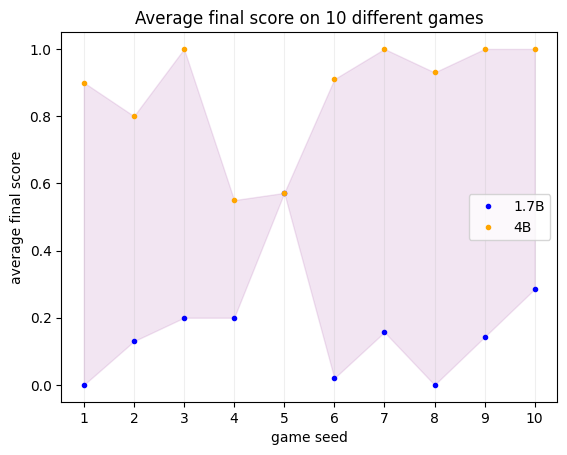

In [ ]:
x = list(seeds) # converting into a list just to be sure, maybe an iterator doesn't work here

fig, ax = plt.subplots()

ax.plot(x, avg_scores_nothink, label="no reasoning", marker=".", linestyle="-", color="red")
ax.plot(x, avg_scores_10think, label="10-turn reasoning", marker=".", linestyle="-", color="orange")
ax.plot(x, avg_scores_5think, label="5-turn reasoning", marker=".", linestyle="-", color="gold")
ax.plot(x, avg_scores_fullthink, label="full reasoning", marker=".", linestyle="-", color="greenyellow")
# ax.fill_between(x, avg_scores_1_7B, avg_scores_4B, alpha=0.1, color="purple")

ax.set_title("Average final score on 10 different games")
ax.set_xlabel('game seed')
ax.set_ylabel('average final score, normalized')

gridlines = np.arange(x[0], x[-1]+1, 1)
ax.set_xticks(gridlines)
ax.grid(axis="x", alpha=0.2)

ax.legend()
plt.show()

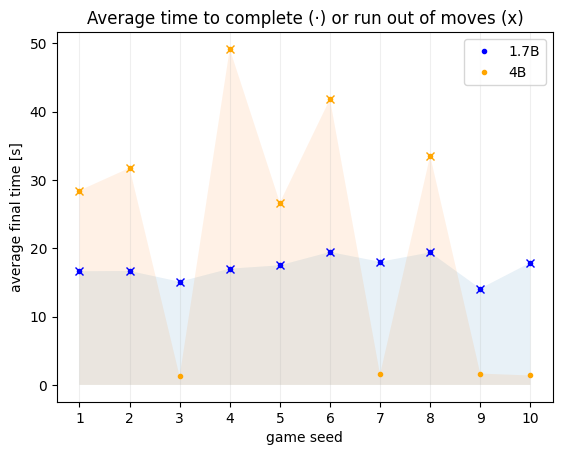

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, avg_scores_nothink, label="no reasoning", marker=".", linestyle="-", color="red")
ax.plot(x, avg_scores_10think, label="10-turn reasoning", marker=".", linestyle="-", color="orange")
ax.plot(x, avg_scores_5think, label="5-turn reasoning", marker=".", linestyle="-", color="gold")
ax.plot(x, avg_scores_fullthink, label="full reasoning", marker=".", linestyle="-", color="greenyellow")

ax.set_title("Average time to complete or run out of moves")
ax.set_xlabel('game seed')
ax.set_ylabel('average final time [s]')

gridlines = np.arange(x[0], x[-1]+1, 1)
ax.set_xticks(gridlines)
ax.grid(axis="x", alpha=0.2)

ax.legend()
plt.show()

# Bundles of tries

In [ ]:
# seed with 10 total score, for clarity
bundle_seed = 11
!tw-make tw-simple --rewards dense --goal detailed --seed 11 --test --silent -f --output games/test-seed11.z8

In [ ]:
results = play(LLMAgentSelfEvaluate(model, tokenizer, selfeval_turns = -1, handheld=False, verbose=False),
        f"./games/test-seed{bundle_seed}.z8", max_steps=max_steps, n_episodes=n_episodes)

with open(f'./Testing 2/nothink_seed{seed}.pickle', 'wb') as f:
    pickle.dump(results, f)
    print("Data pickled.")
    f.close()

In [ ]:
results = play(LLMAgentSelfEvaluate(model, tokenizer, selfeval_turns = 10, handheld=False, verbose=False),
        f"./games/test-seed{bundle_seed}.z8", max_steps=max_steps, n_episodes=n_episodes)

with open(f'./Testing 2/10think_seed{seed}.pickle', 'wb') as f:
    pickle.dump(results, f)
    print("Data pickled.")
    f.close()

In [ ]:
cum_score_index = 1 # (step number, cumulative score, timestamp from beginning of episode)

bundle_nothink = []
bundle_10think = []
cum_scores_nothink = []
cum_scores_10think = []

bundles_cum_scores = [(bundle_nothink, cum_scores_nothink), (bundle_10think, cum_scores_10think)]

with open(f'nothink_seed{bundle_seed}.pickle', 'rb') as f:
        bundle_nothink.append(pickle.load(f))
        f.close()
with open(f'10think_seed{bundle_seed}.pickle', 'rb') as f:
        bundle_10think.append(pickle.load(f))
        f.close()

for i in range(n_episodes):
    for bundle, cum_scores in bundles_cum_scores:
        single_run = []
        for step in bundle:
            single_run.append(step[cum_score_index])
        cum_scores.append(single_run)   

In [ ]:
fig, ax = plt.subplots()
moves = np.arange(0, max_steps+1, 1)

for i in range(n_episodes):
    if i == 0: # set labels just once
        ax.plot(moves, cum_scores_nothink[i], marker=".", linestyle="-", color="red", label="no reasoning")
        ax.plot(moves, cum_scores_10think[i], marker=".", linestyle="-", color="orange", label = "10-turn reasoning")
    else:
        ax.plot(moves, cum_scores_nothink[i], marker=".", linestyle="-", color="red")
        ax.plot(moves, cum_scores_10think[i], marker=".", linestyle="-", color="orange")


ax.set_title("Comparison over 10x2 runs, no reasoning vs 10-turn reasoning")
ax.set_xlabel('moves')
ax.set_ylabel('cumulative score')

major_ticks = np.arange(0, max_steps+1, 10)
minor_ticks = np.arange(0, max_steps+1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(axis="x", which='minor', alpha=0.2)
ax.grid(axis="x", which='major', alpha=0.5)
ax.minorticks_on() # is this still needed since we set some minor ticks? idk

ax.legend()
plt.show()